# FIA-MS data processing and visualization

## Import dependencies

- Requires py v3.9 due to PyOpenMS dependencies
- Requires custom installation of BFAIR (see https://github.com/AutoFlowResearch/BFAIR for instructions on installation)

In [1]:
# General py packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# BFAIR py package
import BFAIR.FIA_MS as fia_ms
import BFAIR.normalization as normalization

# Specific statistics functions from...
# ...scipy
from scipy.stats import spearmanr
import scipy.stats as stats
# ...statsmodels
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests
# ...umap
from umap import UMAP
# ...sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

## Class and function definitions

Define functions and other shared sub-routines not yet integrated into the BFAIR modules

In [231]:
def removeConstFeatures(metabolites, intensities):
    """
    Remove singular or constant features
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    for i, metabolite in enumerate(metabolites):
        row = intensities[intensities["Metabolite"] == metabolite]
        # filter out single- or constant-value features
        if len(row) == 1 or np.std(row["Intensity"]) == 0:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def removeNAFeatures(metabolites, intensities, fraction=0.5):
    """
    Remove features with more than fraction of NAs
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    fraction : float
        the fraction of missing values (i.e., NAs) allowed
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    intensities_filtered_pivot = intensities.pivot(index="sample_group_name", columns="Metabolite", values="Intensity")
    for i, metabolite in enumerate(metabolites):
        if intensities_filtered_pivot[metabolite].isna().sum() / intensities_filtered_pivot.shape[0] > fraction:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def nonParametricRSD(intensities, threshold=0.3):
    """
    Determine the ratio of features in QC samples that
    have a non-parametric %RSD <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Var, RSD, and np_RSD of each metabolite
    ratio_np_RSD: float
        the ratio of features below the threshold
    ratio_RSD: float
        the ratio of features below the threshold
    """
    stats_qc_dict = {}

    for met in intensities["Metabolite"].unique():
        intensities_met = intensities[intensities["Metabolite"] == met]
        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean
        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median
        
        stats_qc_dict[met] = {"Mean" : mean,
                            "Var" : var,
                            "RSD" : rsd,
                            "np_RSD" : np_rsd}

    stats_qc_df = pd.DataFrame.from_dict(stats_qc_dict, "index")
    ratio_np_RSD = stats_qc_df[np.abs(stats_qc_df["np_RSD"]) <= threshold].shape[0] / stats_qc_df.shape[0]
    ratio_RSD = stats_qc_df[np.abs(stats_qc_df["RSD"]) <= threshold].shape[0] / stats_qc_df.shape[0]
    return stats_qc_df, ratio_np_RSD, ratio_RSD

def nonParametricDispersionRatio(intensities, intensities_QCs, threshold=0.5):
    """
    Determine the dispersion ratio of QC samples that
    have a non-parametric ratio <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    intensities_QCs : pandas.DataFrame
        the extracted intensities of only the QCs
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc: pandas.DataFrame
        dataframe with columns for metabolites and the
        dispersion ratio of each metabolite
    ratio_np: float
        the ratio of features below the threshold for
        the non parametric version
    ratio_p: float
        the ratio of features below the threshold for
        the parametric version
    """
    ratio_dict = {}

    for met in intensities["Metabolite"].unique():
        
        intensities_QC_met = intensities_QCs[intensities_QCs["Metabolite"] == met]
        median_qc = np.median(intensities_QC_met["Intensity"])
        mad_qc = np.median(np.absolute(intensities_QC_met["Intensity"] - median_qc))
        sd_qc = np.std(intensities_QC_met["Intensity"])
        
        intensities_met = intensities[intensities["Metabolite"] == met]
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        sd = np.std(intensities_met["Intensity"])
        
        ratio_np = mad_qc / mad
        ratio_p = sd_qc / sd

        ratio_dict[met] = {"dispersion_ratio_np" : ratio_np,
            "dispersion_ratio_p" : ratio_p}

    dispersion_ratio_df = pd.DataFrame.from_dict(ratio_dict, "index")
    dispersion_ratio_np = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_np"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    dispersion_ratio_p = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_p"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    return dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p

def plotPCAwAnnotations(pca, scores, loadings, n_axes = 3, n_features = 50, show_colors=True, show_labels=True):
    """
    Plot PCA Scree plot and PCA data for axes 1 to 3
    
    Parameters
    ----------
    pca : pandas.DataFrame
        Result of SciKitLearn PCA fit_transform
    scores : pandas.DataFrame
        The extracted PCA components (i.e., first 10) with additional
        metadata for "sample_group_name", "replicate_group_name", and "color"
    loadings : pandas.DataFrame
        The extracted PCA loadings (i.e., pca.components_.T, first 10) with additional
        metadata for "Metabolite"
    n_axes: int
        the number of PC axes to show
    n_features: int
        the number top magnitude loadings to show
    show_colors: boolean
        color the points using the "color" column
    show_labels: boolean
        show the "sample_group_name"
    
    Returns
    -------
    none
    """
    # Scree plot
    PC_values = np.arange(pca.n_components_) + 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_title('Scree Plot')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

    # Scores plots
    for j in range(1,n_axes+1):
        for k in range(j+1,n_axes+1):

            # Create a subplot for each PCA axis combination
            fig = plt.figure(figsize = (8,8))
            ax = fig.add_subplot(1,1,1) 
            ax.set_xlabel('Principal Component ' + str(j) + ' ( ' + str(round(pca.explained_variance_ratio_[j-1], 2)) + ' )' , fontsize = 12)
            ax.set_ylabel('Principal Component ' + str(k) + ' ( ' + str(round(pca.explained_variance_ratio_[k-1], 2)) + ' )' , fontsize = 12)
            ax.set_title('PCA (Axis' + str(j) + ' & ' + str(k) + ')', fontsize = 18)

            plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
            plt.xticks(size = 12)
            plt.yticks(size = 12)

            if show_colors:
                # Loop through each PCA axis
                for i, label in enumerate(scores["sample_group_name"]):
                    x, y = scores["PC" + str(j)][i], scores["PC" + str(k)][i]
                    ax.plot(x, y, ".", markersize=15, label=label, color=scores["color"][i])
                    
                    if show_labels:
                        # Annotate the points with the actual names and colors as rounded boxes (only for small sample sizes)
                        ax.annotate(scores["sample_group_name"][i], (x - 0.5 , y), weight='bold',
                                    color='white',
                                    bbox=dict(boxstyle="round",
                                    facecolor=scores["color"][i], edgecolor=scores["color"][i],
                                )
                                )
            else:
                sns.scatterplot(data=scores, x="PC" + str(j), y=scores["PC" + str(k)], 
                    hue="replicate_group_name", ax=ax)
                ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        
    # Loadings plots
    for j in range(1,4):
        # Extract out the top 25 features
        loadings_subset = loadings.filter(["Metabolite", "PC"+ str(j)], axis=1)
        loadings_subset["ABSValue"] = loadings_subset["PC"+ str(j)].abs()
        loadings_subset.sort_values(by="ABSValue", ascending=False, inplace=True)

        # Create a subplot for each PCA axis combination
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        sns.barplot(x="PC"+ str(j), y="Metabolite", data=loadings_subset[0:n_features], ax=ax, color='#99c2a2')
        ax.set_xlabel('Principal Component ' + str(j) + ' ( ' + str(round(pca.explained_variance_ratio_[j-1], 2)) + ' )' , fontsize = 18)
        ax.set_ylabel('Feature' , fontsize = 12)
        ax.set_title('Loadings (Axis ' + str(j) + ')', fontsize = 12)
        ax.tick_params(axis='y', labelsize=8)

        plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)

def addReplicateGroupNameToDF(df, sequence):
    """
    Add the replicate group name to the Metabolite/sample_group_name/Intensities dictionary
    
    Parameters
    ----------
    df : pandas.DataFrame
        the extracted intensities;
    sequence : pandas.DataFrame
        the sequence list corresponding to the extracted intensities
    
    Returns
    -------
    df : pandas.DataFrame
        the update dataframe
    """
    # Add in the replicate group name
    df["replicate_group_name"] = ""
    def getRGNFromSeq(x, seq):
        index = np.where(seq["sample_group_name"] == x)
        return seq["replicate_group_name"][index[0][0]]
    df["replicate_group_name"] = df["sample_group_name"].apply(getRGNFromSeq, seq=sequence)
    return df

def backgroundInterference(intensities_blanks, intensities_unknowns, threshold=0.8, geometric=False):
    """
    Determine the ratio of features in Blanks samples that
    have a median intensity > threshold
    
    Parameters
    ----------
    intensities_blanks : pandas.DataFrame
        the extracted intensities for the Blank samples
    intensities_blanks : pandas.DataFrame
        the extracted intensities for the Unknown (or QC) samples
    threshold: float
        the threshold to use
    geometric: boolean
        whether to apply the threshold in geomtric space
    
    Returns
    -------
    stats_interference_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Median, Var, RSD of each metabolite
    intensities_filtered_df: pandas.DataFrame
        the extracted intensities for the Unknown (or QC) samples 
        filtered after applying the threshold
    n_intensities_removed: float
        the number of intensities in the Unknown (or QC) samples
        that were > threshold*intensity_blank
    """
    stats_blanks_dict = {}
    intensities_filtered_df = pd.DataFrame(columns=intensities_unknowns.columns)
    for met in intensities_blanks["Metabolite"].unique():
        # Determine the blank intensity statistics
        intensities_met = intensities_blanks[intensities_blanks["Metabolite"] == met]        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median        
        stats_blanks_dict[met] = {"Mean" : mean, "Var" : var,
            "Median": median, "RSD" : rsd, "np_RSD" : np_rsd}

        # Filter out metabolites that are > threshold * median
        threshold_cmp = threshold * median
        if geometric:
            threshold_cmp = np.log(threshold) + median
        else:
            if threshold_cmp < 0:
                threshold_cmp = 1 / threshold * median
        intensities_tmp = intensities_unknowns[(intensities_unknowns["Metabolite"] == met) & (intensities_unknowns["Intensity"] > threshold_cmp)]
        tmp = intensities_unknowns[(intensities_unknowns["Metabolite"] == met)]
        intensities_filtered_df = pd.concat([intensities_filtered_df, intensities_tmp], ignore_index=True)
        
    # Finalize the outputs
    stats_interference_df = pd.DataFrame.from_dict(stats_blanks_dict, "index")
    n_intensities_removed = intensities_unknowns.shape[0] - intensities_filtered_df.shape[0]
    return stats_interference_df, intensities_filtered_df, n_intensities_removed

def calcCorrelationCoefficients(intensities, sequence):
    """
    Calculate the Pearson and Spearman correlation
    coefficients
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    sequence : pandas.DataFrame
        the sequence list corresponding to the extracted intensities
    
    Returns
    -------
    pairwise_corr: pandas.DataFrame
        dataframe with columns for the SpearmanR, PearsonR,
        PearsonRPValue, SpearmanRPValue between sample_group_names
        sgn1 and sgn2 for each replicate_group_name
    """
    pairwise_corr_dict = {}
    mets_all = intensities["Metabolite"].unique()
    cnt = 0
    for rgn in sequence["replicate_group_name"].unique():
        sequence_sgn = sequence[sequence["replicate_group_name"] == rgn]
        sgn_set = set()
        for sgn1 in sequence_sgn["sample_group_name"].unique():
            sgn_set.add(sgn1)
            for sgn2 in sequence_sgn["sample_group_name"].unique():
                if sgn2 not in sgn_set:
                    # Extract out dataframes for each pair of samples
                    intensities1 = intensities[intensities["sample_group_name"] == sgn1]
                    intensities2 = intensities[intensities["sample_group_name"] == sgn2]
                    if intensities1.shape[0] == 0 or intensities2.shape[0] == 0:
                        continue

                    # Create a merged dataframe with filled metabolites
                    intensities1 = intensities1.loc[:, ~intensities1.columns.str.contains('^Unnamed')]
                    intensities1.rename(columns={"sample_group_name":"sgn1", "Intensity":"Intensity1"}, inplace = True)
                    intensities1.drop('Formula', axis=1, inplace=True)
                    intensities2 = intensities2.loc[:, ~intensities2.columns.str.contains('^Unnamed')]
                    intensities2.rename(columns={"sample_group_name":"sgn2", "Intensity":"Intensity2"}, inplace = True)
                    intensities2.drop('Formula', axis=1, inplace=True)
                    pairwise_merge = pd.DataFrame(mets_all, columns=["Metabolite"])
                    pairwise_merge = pairwise_merge.merge(intensities1, how='left', on='Metabolite')
                    pairwise_merge = pairwise_merge.merge(intensities2, how='left', on='Metabolite')

                    # Replace all NAs with the minimum value
                    pairwise_merge = pairwise_merge[~pairwise_merge["Intensity1"].isna() & ~pairwise_merge["Intensity2"].isna()]
                    min_value = np.min([pairwise_merge["Intensity1"].min(), pairwise_merge["Intensity2"].min()])
                    pairwise_merge.fillna(min_value, inplace=True)

                    # Calculate the correlation coefficients
                    pearsonR = stats.pearsonr(pairwise_merge['Intensity1'], pairwise_merge['Intensity2'])
                    spearmanR = spearmanr(pairwise_merge['Intensity1'], pairwise_merge['Intensity2'])
                    pairwise_corr_dict[cnt] = {"replicate_group_name": rgn, 
                        "sgn1":sgn1, "sgn2":sgn2, 
                        "PearsonR":pearsonR[0], "SpearmanR": spearmanR[0], 
                        "PearsonRPValue":pearsonR[1], "SpearmanRPValue": spearmanR[1]}
                    cnt = cnt + 1
    pairwise_corr = pd.DataFrame.from_dict(pairwise_corr_dict, "index")
    pairwise_corr.sort_values(by="replicate_group_name", ascending=True, inplace=True)
    return pairwise_corr

def countNonCorrelatedReps(pairwise_corr, threshold_stat = "PearsonR", threshold_corr = 0.9):
    """
    Count the number of non-correlated replicates
    based on a user defined threshold and metric
    
    Parameters
    ----------
    pairwise_corr : pandas.DataFrame
        pre-computed pairwise correlation statistics
        using calcCorrelationCoefficients;
    threshold_stat : string
        the column name of the statistic to use
    threshold_corr : float
        the correlation value to use as a threshold
    
    Returns
    -------
    sgn_cnt_df: pandas.DataFrame
        dataframe with columns for the  sample_group_name,
        replicate_group_name, count, and reject
    """
    # Determine the replicates for each replicate_group_name
    # Note that the # of unique comparisons for k conditions is k(k-1)/2
    # therefore k(k-1)/2 = c, and k = (1 +/- sqrt(1+8c))/2 by the
    # quadratic formula 
    rgn_unique = pairwise_corr["replicate_group_name"].unique()
    rgn_cnt_dict = {}
    cnt = 0
    for rgn in rgn_unique:
        tmp = pairwise_corr[(pairwise_corr["replicate_group_name"] == rgn)]
        n_comp = (1.0 + np.sqrt(1.0 + 8.0 * tmp.shape[0]))/2.0
        rgn_cnt_dict[cnt] = {"replicate_group_name":rgn, "comparisons":tmp.shape[0], "replicates":n_comp}
        cnt = cnt + 1
    rgn_cnt_df = pd.DataFrame.from_dict(rgn_cnt_dict, "Index")

    # Count the number of sample_group_names that appear as outliers
    pairwise_corr_threshold = pairwise_corr[(pairwise_corr[threshold_stat] < threshold_corr)]
    sgn_unique = set()
    sgn_unique.update(pairwise_corr_threshold["sgn1"].unique())
    sgn_unique.update(pairwise_corr_threshold["sgn2"].unique())
    sgn_cnt_dict = {}
    cnt = 0
    for sgn in sgn_unique:
        tmp_sgn_df = pairwise_corr_threshold[(pairwise_corr_threshold["sgn1"] == sgn) | (pairwise_corr_threshold["sgn2"] == sgn)]
        count = tmp_sgn_df.shape[0]
        rgn = tmp_sgn_df["replicate_group_name"].to_list()[0]

        # outliers are those replicates that appear k-1 times
        reject = False
        tmp_rgn_df = rgn_cnt_df[(rgn_cnt_df["replicate_group_name"]==rgn) & (rgn_cnt_df["replicates"] - 1 <= count)]
        if tmp_rgn_df.shape[0]>0:
            reject = True

        sgn_cnt_dict[cnt] = {"replicate_group_name": rgn, "sample_group_name":sgn, "count":count, "reject":reject}
        cnt = cnt + 1
    sgn_cnt_df = pd.DataFrame.from_dict(sgn_cnt_dict, "Index")
    return sgn_cnt_df

def removeNonCorrelatedReps(intensities, sequence, threshold_stat = "PearsonR", threshold_corr = 0.9, max_iters = 10):
    """
    Count the number of non-correlated replicates
    based on a user defined threshold and metric
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    sequence : pandas.DataFrame
        the sequence list corresponding to the extracted intensities
    threshold_stat : string
        the column name of the statistic to use
    threshold_corr : float
        the correlation value to use as a threshold
    max_iters : int
        the maximum number of iterations
    
    Returns
    -------
    pairwise_corr: pandas.DataFrame
        dataframe with columns for the SpearmanR, PearsonR,
        PearsonRPValue, SpearmanRPValue between sample_group_names
        sgn1 and sgn2 for each replicate_group_name
    sgn_reject: list
        list of strings proving the sample_group_names
        that fail the test
    """
    sgn_reject = []
    # Calculate the correlation coefficient between replicates
    pairwise_corr = calcCorrelationCoefficients(intensities, sequence)

    # Count the number of non-correlated reps
    sgn_cnt_df = countNonCorrelatedReps(pairwise_corr, threshold_stat, threshold_corr)

    # Begin iteratively remove replicates
    for i in range(max_iters):
        if sgn_cnt_df.empty:
            break

        tmp = sgn_cnt_df[sgn_cnt_df["reject"]]
        print("Round # ", i, " filtered replicates = ", tmp.shape[0])

        if tmp.shape[0] > 0:
            sgn_reject = list(set(sgn_reject + list(tmp["sample_group_name"].unique())))
            # Filter and re-run the correlation calculation
            sgn_keep = sgn_cnt_df[~sgn_cnt_df["reject"]]
            tmp = intensities[intensities["sample_group_name"].isin(sgn_keep["sample_group_name"].unique())]
            pairwise_corr = calcCorrelationCoefficients(tmp, sequence)

            # Count the number of non-correlated reps
            sgn_cnt_df = countNonCorrelatedReps(pairwise_corr, threshold_stat, threshold_corr)
        else:
            break

    return pairwise_corr, sgn_reject

def calcZScore(intensities_metric, metric="Median"):
    """
    Calculate the Z Scores
    
    Parameters
    ----------
    intensities_metric : pandas.DataFrame
        the extracted mean/median/var/rsd from `calculateMeanVarRSD`
    metric : string
        metric to used for the Z score (i.e., median or mean)
    
    Returns
    -------
    z_score: pandas.DataFrame
        dataframe with columns for the replicate_group_name,
        Metabolite, Formula, ZScore
    """
    z_score_dict = {}
    mets_all = intensities_metric["Metabolite"].unique()
    cnt = 0
    for met in mets_all:
        intensities_all = intensities_metric[intensities_metric["Metabolite"] == met]
        if intensities_all.shape[0] == 0:
            continue
        for rgn in intensities_metric["replicate_group_name"].unique():
            intensities_z = intensities_all[intensities_all["replicate_group_name"] == rgn]
            if intensities_z.shape[0] == 0:
                continue
            metric_value = intensities_z[metric].tolist()[0]
            z_score, p_value = ztest(intensities_all[metric], value=metric_value)
            z_score_dict[cnt] = {"replicate_group_name": rgn, 
                "ZScore":z_score, "PValue":p_value,
                "Metabolite":met}
            cnt = cnt + 1    
    z_score = pd.DataFrame.from_dict(z_score_dict, "index")
    z_score.sort_values(by=["replicate_group_name","Metabolite"], ascending=True, inplace=True)
    
    # calculate the adjusted p_values
    reject, corrected_p_value, a_, b_ = multipletests(z_score["PValue"], 0.01, 'bonferroni')
    z_score["QValue"] = corrected_p_value
    z_score["NegLog10QValue"] = -np.log(z_score["QValue"])
    return z_score

def calcVolcanoStats(intensities, intensities_metric, 
    metric="Median", geometric=False, threshold_neglog10pval = 2.0, threshold_log2fc = 1.0):
    """
    Calculate the pairwise fold-change, Welches t-test
    statistics between replicate_group_names
    corresponding to a volcano plot
    
    Parameters
    ----------    
    intensities : pandas.DataFrame
        the extracted intensities;
        with the replicate_group_name added after calling `addReplicateGroupNameToDF`
    intensities_metric : pandas.DataFrame
        the extracted mean/median/var/rsd from `calculateMeanVarRSD`
    metric : string
        metric to used for the Z score (i.e., median or mean)
    geometric: boolean
        whether to apply the threshold in geometric space
    threshold_neglog10pval: float
        the cutoff for statistical significance based on the
        Negative Log10 p-value (default=2.0)
    threshold_log2fc: float
        the cutoff for magnitude foldchange based on the
        aboslute Log2 fold-change (default=1.0)
    
    Returns
    -------
    volcano: pandas.DataFrame
        dataframe with columns for the TTest, PValue, NegLog10PValue
        FoldChange, Log2FoldChange, and Significant between 
        replicate_group_names rgn1 and rgn2 for values
        value1 and value2
    """
    volcano_dict = {}
    mets_all = intensities_metric["Metabolite"].unique()
    rgn_all = intensities_metric["replicate_group_name"].unique()
    cnt = 0
    for met in mets_all:
        rgn_set = set()
        intensities_met = intensities[intensities["Metabolite"] == met]
        intensities_metric_met = intensities_metric[
            intensities_metric["Metabolite"] == met]
        if intensities_met.shape[0] == 0 or intensities_metric_met.shape[0] == 0:
            continue
        for rgn1 in rgn_all:
            rgn_set.add(rgn1)
            for rgn2 in rgn_all:
                if rgn2 in rgn_set:
                    continue
                # Extract out dataframes for each pair of samples
                intensities1 = intensities_met[
                    (intensities_met["replicate_group_name"] == rgn1)]
                intensities2 = intensities_met[
                    (intensities_met["replicate_group_name"] == rgn2) ]
                intensities_metric1 = intensities_metric_met[
                    (intensities_metric_met["replicate_group_name"] == rgn1)]
                intensities_metric2 = intensities_metric_met[
                    (intensities_metric_met["replicate_group_name"] == rgn2) ]

                # Predefine the variables of interest
                t_test = p_value = value_metric1 = value_metric2 = fc \
                    = fclog2 = neglog10pval = n1 = n2 = np.NaN
                significant = False

                # Compute the variables based on the following
                if (intensities1.shape[0] == 0 and intensities2.shape[0] == 0) \
                    or (intensities_metric1.shape[0] == 0 and intensities_metric2.shape[0] == 0):
                    continue
                elif intensities1.shape[0] == 0 and intensities2.shape[0] > 1 \
                    and intensities_metric1.shape[0] == 0 and intensities_metric2.shape[0] != 0:
                    value_metric2 = intensities_metric2[metric].tolist()[0]
                    n2 = intensities2.shape[0]
                    significant = True
                elif intensities1.shape[0] > 1 and intensities2.shape[0] == 0 \
                    and intensities_metric1.shape[0] != 0 and intensities_metric2.shape[0] == 0:
                    value_metric1 = intensities_metric1[metric].tolist()[0]
                    n1 = intensities1.shape[0]
                    significant = True
                elif intensities1.shape[0] != 0 and intensities2.shape[0] != 0 \
                    and intensities_metric1.shape[0] != 0 and intensities_metric2.shape[0] != 0:

                    # Calculate the fold change and paired t-test
                    t_test, p_value = stats.ttest_ind(intensities1['Intensity'], intensities2['Intensity'], equal_var=False)
                    neglog10pval = -np.log10(p_value)
                    value_metric1 = intensities_metric1[metric].tolist()[0]
                    value_metric2 = intensities_metric2[metric].tolist()[0]
                    fc = value_metric2/value_metric1
                    fclog2 = np.log2(fc)
                    if geometric:
                        fc = value_metric2 - value_metric1
                        fclog2 = np.log2(np.exp(fc))
                    n1 = intensities1.shape[0]
                    n2 = intensities2.shape[0]

                    # Determine significance based on fold change and pvalue
                    significant = False
                    if n1 == 1 and n2 == 1 and np.abs(fclog2) >= threshold_log2fc:
                        significant = False
                    elif (n1 == 1 or n2 == 1) and np.abs(fclog2) >= threshold_log2fc:
                        significant = True
                    elif np.abs(fclog2) >= threshold_log2fc and neglog10pval >= threshold_neglog10pval:
                        significant = True
                
                else:
                    continue

                # Create the dict data structure
                volcano_dict[cnt] = { "Metabolite":met,
                    "rgn1":rgn1, "rgn2":rgn2, 
                    "value1":value_metric1, "value2":value_metric2,
                    "n1":n1, "n2": n2,
                    "TTest":t_test, "PValue": p_value, 
                    "NegLog10PValue":neglog10pval, 
                    "FoldChange": fc, 
                    "Log2FoldChange":fclog2,
                    "Significant":significant}
                cnt = cnt + 1
    volcano = pd.DataFrame.from_dict(volcano_dict, "index")
    volcano.sort_values(by="Metabolite", ascending=True, inplace=True)
    return volcano


## Read in the data

Set the directories

In [9]:
work_dir = "C:/Users/dmccl/Downloads"
batch_name = "KALEOnScale"
run_name = "KALEOnScale"
load_from_cache = False

if run_name == "Bruker":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_Bruker"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_ScimaX"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Bruker_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Bruker_MeanVarRSD.csv"
elif run_name == "Orbitrap1":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_DTU"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap1_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap1_MeanVarRSD.csv"
elif run_name == "Orbitrap2":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_round2"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-02_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap2_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap2_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap2_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap2_MeanVarRSD.csv"
elif run_name == "KALEOnScale":
    feature_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20220101_FIA_MS_KALEOnScale/Features2" #"Z:/Douglas/AutoFlow data/SmartPeakBackup/20220101_FIA_MS_KALEOnScale/Features"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20220101_FIA_MS_KALEOnScale"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20220101_FIA_MS_KALEOnScale/CHEMISTRY"
    database_file = "/iJO1366_struct1.tsv" #"/iJO1366_struct.tsv"
    sequence_file = "/sequence.csv" #"/sequence1.csv"
    intensities_file = "/KALEOnScale_Intensities.csv" #"/KALEOnScale_Intensities1.csv"
    MeanVarRSD_file = "/KALEOnScale_MeanVarRSD.csv" #"/KALEOnScale_MeanVarRSD1.csv"


Read in the sequence and remove blank rows

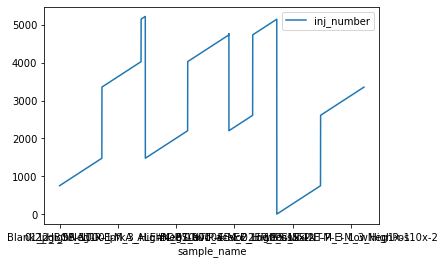

In [10]:
sequence = pd.read_csv(sequence_dir + sequence_file, sep=",")
sequence = sequence[sequence["sample_name"].str.contains("BLANK") == False]

# Quick QC of the data
sequence.plot(x="sample_name", y="inj_number", kind="line")

Read in the database file

In [11]:
database = pd.read_csv(database_dir + database_file, sep="\t", header=None)
database = database.drop(database[database.iloc[:,0].str.contains("EXTRA")].index)

Extract all the relevant information from the provided .featureXML files

In [12]:
# Read in the intensities for .FeatureXML
if load_from_cache:
    intensities = pd.read_csv(work_dir + intensities_file, index_col=0)
else:
    intensities = fia_ms.extractNamesAndIntensities(feature_dir, sequence["sample_group_name"].unique(), database)
    
    # Remove "HMDB:" from metabolite IDs
    #intensities["Metabolite"] = intensities["Metabolite"].str.replace("HMDB:", "")

    # Export to csv
    intensities.to_csv(work_dir + intensities_file)

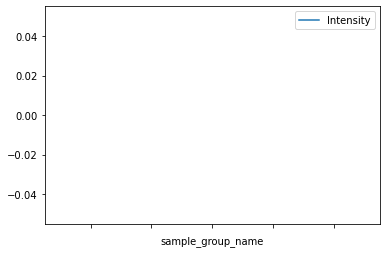

In [13]:
# Quick QC of the data
intensities_selected = intensities[intensities["Metabolite"] == "glu_D[c]"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")

## Data filtering, normalization, quality control (QC), and basic statistical analysis

Data filtering #1: remove single and constant value features

In [14]:
metabolites = intensities["Metabolite"].unique()

intensities_filtered = removeConstFeatures(metabolites, intensities)
print("Intensities ", intensities.shape[0])
print("Intensities filtered ", intensities_filtered.shape[0])
print("Intensities difference ", intensities.shape[0] - intensities_filtered.shape[0])

Intensities  237948
Intensities filtered  237922
Intensities difference  26


Date filtering #2: remove features with more than 50% NAs

In [15]:
metabolites = intensities_filtered["Metabolite"].unique()

intensities_filtered = removeNAFeatures(metabolites, intensities_filtered, 0.99)
print("Percent filtered ", 100 * (1 - (intensities_filtered.shape[0]/intensities.shape[0])))

Percent filtered  0.1218753677273976


Data QC #1: non-parametric %RSD

In [16]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  0.4482758620689655
Percent QC features with RSD <= 0.3  0.28663793103448276


Data QC #2: non-parametric dispersion ratio

In [17]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_filtered, intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percent non parametric dispersion ratio <= 0.5  0.5711864406779661
Percent parametric dispersion ratio <= 0.5  0.6610169491525424


Data normalize #1: Total sum intensity (tsi) sample normalization and log transformation

C:\Users\dmccl\AppData\Local\Temp\ipykernel_34472\3929831034.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  intensities_tsi_selected = intensities_tsi[(intensities_tsi["Metabolite"] == "glu_D[c]") | (intensities["Metabolite"] == "glu__D_c")]


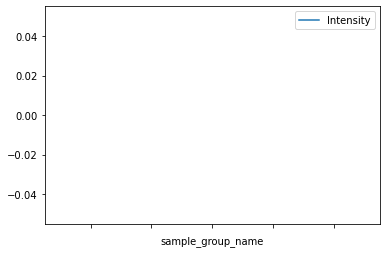

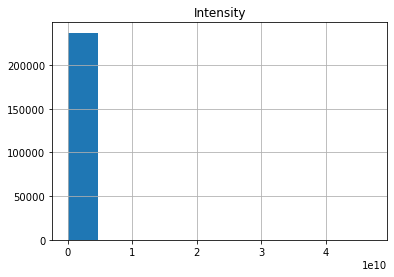

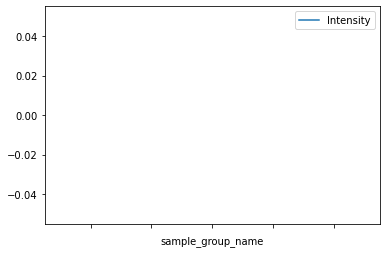

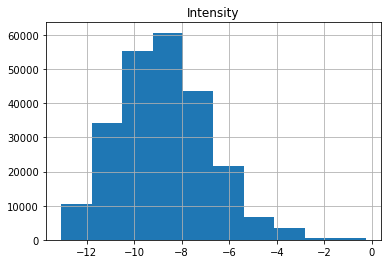

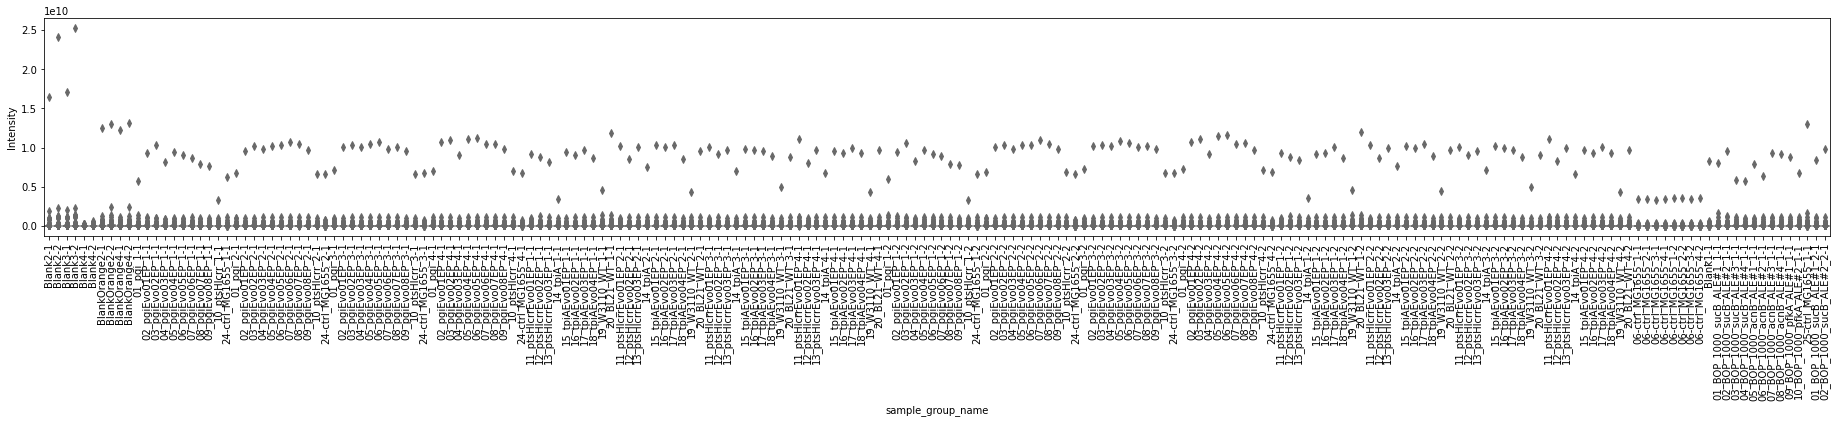

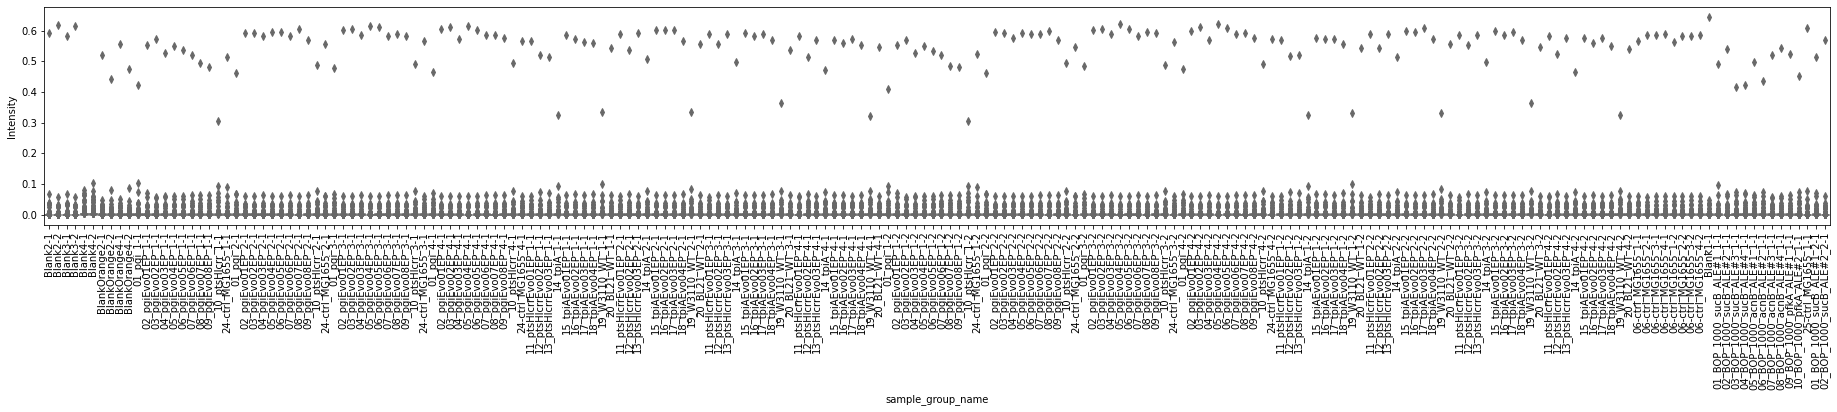

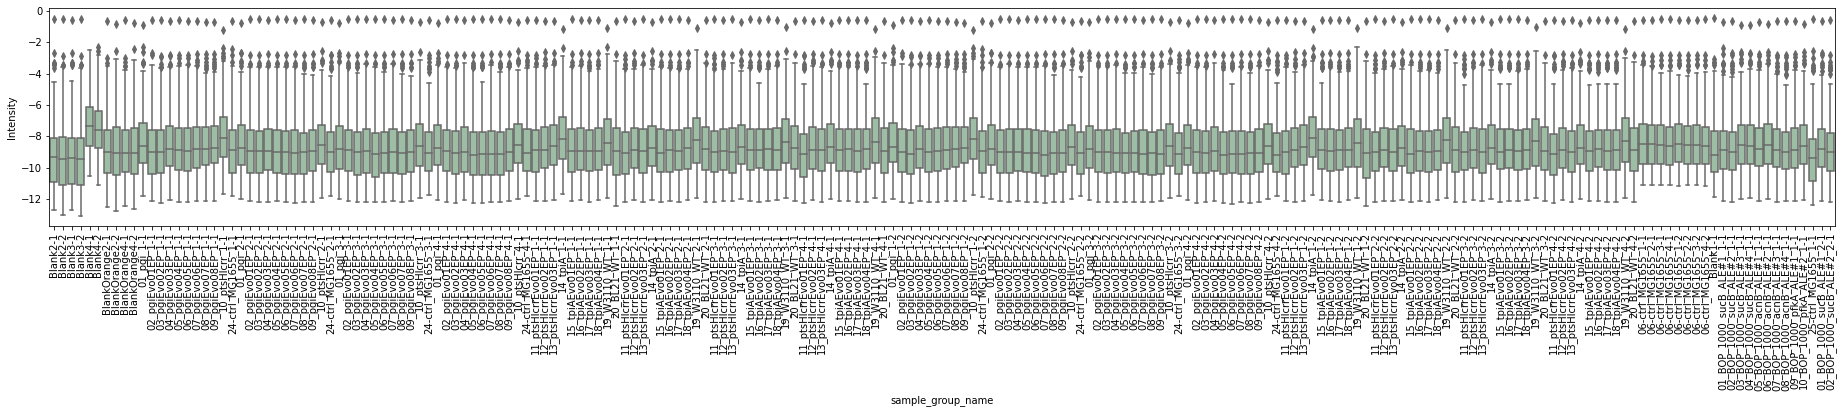

In [18]:
# TSI and log transformation
intensities_tsi = normalization.tsi_norm(intensities_filtered)
intensities_tsi["Intensity"] = np.log(intensities_tsi["Intensity"])

# Plot the distribution of select/all intensities
intensities_filtered_selected = intensities[(intensities["Metabolite"] == "glu_D[c]") | (intensities["Metabolite"] == "glu__D_c")]
intensities_filtered_selected.plot(x="sample_group_name", y="Intensity", kind="line")
intensities_filtered.hist("Intensity")
intensities_tsi_selected = intensities_tsi[(intensities_tsi["Metabolite"] == "glu_D[c]") | (intensities["Metabolite"] == "glu__D_c")]
intensities_tsi_selected.plot(x="sample_group_name", y="Intensity", kind="line")
intensities_tsi.hist("Intensity")

# Use a selection (Blanks and Unkowns) of sample types to visualize the affects of normalization
sequence_blanks_unknowns = sequence[sequence["sample_type"].str.contains("Blank") | sequence["sample_type"].str.contains("Unknown")]
intensities_filtered_plot = intensities_filtered[intensities_filtered["sample_group_name"].isin(sequence_blanks_unknowns["sample_group_name"].unique()[0:200])]
tmp_tsi = normalization.tsi_norm(intensities_filtered_plot)
tmp_tsi["Intensity"] = np.log(tmp_tsi["Intensity"])

# Plot the distribution of intensities as boxplots for different normalizations
fig1 = plt.figure(figsize = (32,4))
ax1 = fig1.add_subplot(1,1,1) 
sns.boxplot(x='sample_group_name', y='Intensity', data=intensities_filtered_plot, color='#99c2a2', ax=ax1)
ax1.tick_params(axis='x', rotation=90)
fig2 = plt.figure(figsize = (32,4))
ax2 = fig2.add_subplot(1,1,1) 
sns.boxplot(x='sample_group_name', y='Intensity', data=normalization.tsi_norm(intensities_filtered_plot), color='#99c2a2', ax=ax2)
ax2.tick_params(axis='x', rotation=90)
fig3 = plt.figure(figsize = (32,4))
ax3 = fig3.add_subplot(1,1,1) 
sns.boxplot(x='sample_group_name', y='Intensity', data=tmp_tsi, color='#99c2a2', ax=ax3)
ax3.tick_params(axis='x', rotation=90)

Data QC #3: parametric %RSD

In [19]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(normalized_intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  1.0
Percent QC features with RSD <= 0.3  0.9935344827586207


Data QC #4: parametric dispersion ratio

In [20]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_tsi, normalized_intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percent non parametric dispersion ratio <= 0.5  0.36271186440677966
Percent parametric dispersion ratio <= 0.5  0.2305084745762712


Data filtering #3: remove high variable features (QC > 30% RSD)

In [21]:
to_discard = stats_qc_df[np.abs(stats_qc_df["RSD"]) > 0.3]
to_discard.index.name = 'Metabolite'
to_discard.reset_index(inplace=True)
intensities_tsi_filt = intensities_tsi[~intensities_tsi["Metabolite"].isin(to_discard["Metabolite"])]

print("Intensities ", intensities_tsi.shape[0])
print("Intensities filtered ", intensities_tsi_filt.shape[0])
print("Intensities difference ", intensities_tsi.shape[0] - intensities_tsi_filt.shape[0])

Intensities  237658
Intensities filtered  235739
Intensities difference  1919


Data QC #5: Check technical replicate correlation (R > 0.9)

In [22]:
# Calculate the correlation coefficient between replicates
sequence_unknowns = sequence[sequence["sample_type"] == "Unknown"]
tmp = intensities_tsi_filt[intensities_tsi_filt["sample_group_name"].isin(sequence_unknowns["sample_group_name"].unique())]
pairwise_corr = sgn_reject = []
# if run_name == "Bruker":
#     pairwise_corr, sgn_reject = removeNonCorrelatedReps(tmp, sequence, "PearsonR", 0.8, 10)
# else:
#     pairwise_corr, sgn_reject = removeNonCorrelatedReps(tmp, sequence, "SpearmanR", 0.9, 10)

In [23]:
# Visualize the distribution of correlation coefficients
print("Min/Max pearson's R", pairwise_corr["PearsonR"].min(), pairwise_corr["PearsonR"].max())
print("Min/Max spearman's R", pairwise_corr["SpearmanR"].min(), pairwise_corr["SpearmanR"].max())
pairwise_corr.hist("PearsonR")
pairwise_corr.hist("SpearmanR")

# Plot a matrix of correlation coefficients
pairwise_corr_piv = pairwise_corr.pivot("sgn1", "sgn2", "PearsonR")
pairwise_corr_piv.fillna(0, inplace=True)

plt.figure(figsize=(16,12))
heat_map = sns.heatmap(pairwise_corr_piv, linewidth = 1, annot = False)
plt.title("Pairwise Pearson's R")

TypeError: list indices must be integers or slices, not str

Data filtering #4: remove samples without the minimum number of replicates, highly variable features (> 50% RSD), and non-correlated replicates

In [24]:
%%capture
if load_from_cache:
    intensities_stats = pd.read_csv(work_dir + MeanVarRSD_file)
else:
    intensities_stats = fia_ms.calculateMeanVarRSD(intensities_tsi_filt, sequence.drop_duplicates(["sample_group_name", "replicate_group_name"]), min_reps=2)

    # Export to csv
    intensities_stats.to_csv(work_dir + MeanVarRSD_file)

In [25]:
# Filter metabolites
to_discard = intensities_stats[np.abs(intensities_stats["RSD"]) > 0.5]
to_discard_mets = to_discard["Metabolite"].unique()

# Filter sample_group_names
outlier_rgns = ["exo-48-SD-None-CKO-3-3-Neg10x-1", "exo-48-SD-None-CKO-3-3-Neg10x-2", "endo-48-SD-None-CKO-3-3-Neg10x-1", "endo-48-SD-None-CKO-3-3-Neg10x-2",
    "exo-48-SD-None-CKO-3-3-Pos10x-1", "exo-48-SD-None-CKO-3-3-Pos10x-2", "endo-48-SD-None-CKO-3-3-Pos10x-1", "endo-48-SD-None-CKO-3-3-Pos10x-2"]

to_remove_injections = sequence[sequence["sample_group_name"].isin(outlier_rgns) 
    | sequence["sample_group_name"].isin(sgn_reject) 
    | ~sequence["replicate_group_name"].isin(intensities_stats["replicate_group_name"])
]

intensities_tsi_filt2 = intensities_tsi_filt[~intensities_tsi_filt["Metabolite"].isin(to_discard_mets)
    & ~intensities_tsi_filt["sample_group_name"].isin(to_remove_injections["sample_group_name"].unique())
]
print("n discarded metabolites", len(to_discard_mets))
print("n discarded injections", len(to_remove_injections))
print("Intensities ", intensities_tsi_filt.shape[0])
print("Intensities filtered ", intensities_tsi_filt2.shape[0])
print("Intensities difference ", intensities_tsi_filt.shape[0] - intensities_tsi_filt2.shape[0])

n discarded metabolites 1
n discarded injections 36
Intensities  235739
Intensities filtered  234568
Intensities difference  1171


Data QC #6: Visualization of the RSD

Text(0.5, 1.0, 'RSD')

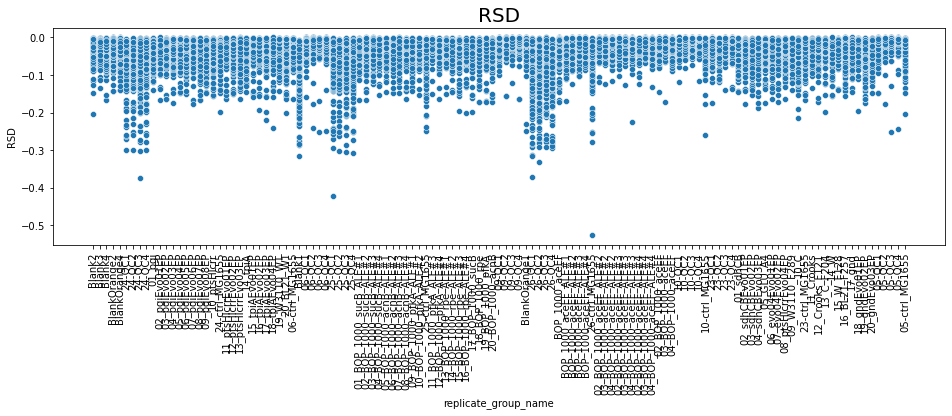

In [26]:
fig = plt.figure(figsize = (16,4))
ax = sns.scatterplot(x="replicate_group_name", y="RSD", data=intensities_stats)
plt.xticks(rotation=90)
plt.title('RSD', size = 20)

Data QC #7: background interference; note that we need to take into account the background media and whether the sample is endo or exo

In [27]:
# Define the cohorts of replicate_group_names
# rgns = sequence["replicate_group_name2"].unique()
# rgns.sort()
# print(rgns)

KALEOnScale = ['01_pgi','01_sdhCB','10_ptsHlcrr','17_gnd','14_tpiA','05_GLU_A4',
'02_pgiEvo01EP','03_pgiEvo02EP','04_pgiEvo03EP','05_pgiEvo04EP','06_pgiEvo05EP','07_pgiEvo06EP','08_pgiEvo07EP','09_pgiEvo08EP',
'02_sdhCBEvo01EP','03_sdhCBEvo02EP','04_sdhCBEvo03EP',
'06_evo04Evo01EP','07_evo04Evo02EP',
'11_ptsHIcrrEvo01EP','12_ptsHIcrrEvo02EP','13_ptsHIcrrEvo03EP','08_ptsHIcrrEvo04EP',
'06-ctrl_MG1655','10-ctrl_MG1655',
'15_tpiAEvo01EP','16_tpiAEvo02EP','17_tpiAEvo03EP','18_tpiAEvo04EP',
'18_gndEvo01EP','19_gndEvo02EP','20_gndEvo03EP',
'23-ctrl_MG1655','24-ctrl_MG1655','25-ctrl_MG1655','26-ctrl_MG1655',
'Blank1','Blank2','Blank3','Blank4',
'BlankOrange','BlankOrange1','BlankOrange2','BlankOrange3','BlankOrange4']

IndustrialStrains = ["19_W3110_WT","20_BL21_WT","09_W3110_F289","10_C","11_Crooks",
"12_Crooks_F121","13_C_F204","14_W","15_W_F128","16_BL21_F257",
'23-ctrl_MG1655','24-ctrl_MG1655','25-ctrl_MG1655','26-ctrl_MG1655',
'Blank1','Blank2','Blank3','Blank4',
'BlankOrange','BlankOrange1','BlankOrange2','BlankOrange3','BlankOrange4']

BOPKALE = ["01_BOP_1000_sucB_ALE#1","02_BOP_1000_sucB_ALE#2","03_BOP_1000_sucB_ALE#3","04_BOP_1000_sucB_ALE#4",
"05_BOP_1000_acnB_ALE#1","06_BOP_1000_acnB_ALE#2","07_BOP_1000_acnB_ALE#3","08_BOP_1000_acnB_ALE#4",
"09_BOP_1000_pfkA_ALE#1","10_BOP_1000_pfkA_ALE#2","11_BOP_1000_pfkA_ALE#3","12_BOP_1000_pfkA_ALE#4",
"13_BOP_1000_rpe_ALE#1","14_BOP_1000_rpe_ALE#2","15_BOP_1000_rpe_ALE#3","16_BOP_1000_rpe_ALE#4",
"17_BOP_1000_sucB","18_BOP_1000_rpe","19_BOP_1000_pfkA","20_BOP_1000_acnB","BOP_1000_aceEF",
"BOP_1000_aceEF_ALE#1","BOP_1000_aceEF_ALE#2","BOP_1000_aceEF_ALE#3","BOP_1000_aceEF_ALE#4",
'23-ctrl_MG1655','24-ctrl_MG1655','25-ctrl_MG1655','26-ctrl_MG1655',
'Blank1','Blank2','Blank3','Blank4',
'BlankOrange','BlankOrange1','BlankOrange2','BlankOrange3','BlankOrange4']

In [255]:
# Blanks and Unknowns/QCs
# sequence_blanks = sequence[sequence["sample_type"].str.contains("Blank") & sequence["replicate_group_name"].str.contains("endo-") & sequence["scan_polarity"].str.contains("positive")]
# sequence_notblanks = sequence[~sequence["sample_type"].str.contains("Blank") & sequence["replicate_group_name"].str.contains("endo-") & sequence["scan_polarity"].str.contains("positive")]
sequence_blanks = sequence[sequence["sample_type"].str.contains("Blank") & sequence["scan_polarity"].str.contains("negative") & sequence["replicate_group_name"].isin(KALEOnScale)]
sequence_notblanks = sequence[~sequence["sample_type"].str.contains("Blank") & sequence["scan_polarity"].str.contains("negative") & sequence["replicate_group_name"].isin(KALEOnScale)]
normalized_intensities_Blanks = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_blanks["sample_group_name"])]
normalized_intensities_Unknowns = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_notblanks["sample_group_name"])]

# Remove background interferences
stats_interference_df, intensities_filtered_df, n_intensities_removed = backgroundInterference(normalized_intensities_Blanks, normalized_intensities_Unknowns, 0.8, True)
print("N intensities removed ", n_intensities_removed)
print("N intensities remaining ", intensities_filtered_df.shape[0])
print("Percent intensities removed ", n_intensities_removed/normalized_intensities_Unknowns.shape[0])

N intensities removed  53588
N intensities remaining  49756
Percent intensities removed  0.5185400216751819


Data QC #5: PCA of replicates, blanks, and QCs

In [256]:
# Split into smaller subsets by batch, polarity, compartment, etc.
batch_names = ["MetEngDemo","NPDemo"]
scan_polaritie = ["positive","negative"]
sample_types = ["Blank","QC","Unknown"]
cellular_locations = ["exo-", "endo-"]

time_points = ["48","96","144"]
media_types = ["MG","ISP2"]
media_types = ["YPDFeed-None","YPDFeed-Supp","YPDNoFeed-None","YPDNoFeed-Supp"]

time_points = ["0","336","144"]
plate_types = ["Plate96","Plate96Bead","Plate96Spring","Plate24","Plate24Bead","Plate24Spring"]
cell_types = ["StrepColTu365", "StrepGriseoJ1074"]

# Define the sequence subsets using the pattern batch_name/scan_polarity/sample_type/cellular_location
sequence_Unknown = sequence[
    #sequence["batch_name"].str.contains("MetEngDemo") 
    #sequence["batch_name"].str.contains(r'\b(?:{})\b'.format('|'.join(["NPDemo","NatProdDemo"])))
    sequence["sample_type"].str.contains("Unknown")
    #& sequence["replicate_group_name"].str.contains("pgi")
    #& (sequence["replicate_group_name"].str.contains("ptsHIcrr") | sequence["replicate_group_name"].str.contains("ptsHlcrr"))
    #& sequence["replicate_group_name"].str.contains("144-")
    #& (sequence["dilution_factor"] == 1.0)
    ]
sequence_QC = sequence[
    #sequence["batch_name"].str.contains("MetEngDemo") 
    (sequence["sample_type"].str.contains("QC") | sequence["sample_type"].str.contains("Blank"))
    #& sequence["scan_polarity"].str.contains("negative")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]

# Create the subset and pivot table
intensities_subset = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_Unknown["sample_group_name"].unique())]
#intensities_subset = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_QC["sample_group_name"].unique())]
intensities_piv = intensities_subset.pivot("sample_group_name", "Metabolite", "Intensity")
intensities_piv.fillna(intensities_subset["Intensity"].min(), inplace=True)
sequence_subset = sequence_Unknown
#sequence_subset = sequence_QC
print(intensities_piv.shape[0])

288


In [257]:
# Standardize the data
scaler = StandardScaler()
intensities_piv_scaled = scaler.fit_transform(intensities_piv)

# pca
pca = PCA(n_components = 10)
comps = pca.fit_transform(intensities_piv_scaled)

In [258]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2',
    'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

# add in the Metabolite
loadings["Metabolite"] = intensities_piv.columns

In [338]:
# plot the scores
scores = pd.DataFrame(data = comps, columns =  ['PC1', 'PC2',
    'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

# add in the sample_group_names as the labels
scores["sample_group_name"] = intensities_piv.index

# add in the replicate_group_name to define the colors
scores["replicate_group_name"] = ""
for i,row in scores.iterrows():
    index = np.where(sequence["sample_group_name"] == row["sample_group_name"])[0]
    # scores.loc[:, "replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]
    scores.loc[:, "replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]][3:] # KALEOnScale: prune the first 3 digits e.g., 01_

# define the colors based on various criteria
# color palette = ["#000000", "#929292", "#0037ea", "#00b5ff", "#4cfeb2", "#4c98fe", "#f1fe4c", "#fe594c", "#feb24c"]
scores.loc[:, "color"] = ""
annotation = "dilution"
for i,row in scores.iterrows():
    if annotation == "QC":
        ## MetEengDemo
        if row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Pos":
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Neg":
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif row["replicate_group_name"] == "endo-0-YPDSD-NA-QCPool_Pos":
            scores.loc[:, "color"].iloc[i] = "#4cfeb2"
        elif row["replicate_group_name"] == "endo-0-YPDSD-NA-QCPool_Neg":
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "None-None" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "QCCellFilt" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#feb24c"
        elif "Supp-None" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#fe594c"
        ## NPDemo
        elif "endo-0-ISP2MG-NA-QCPoolStrepColTu365_Neg" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "endo-0-ISP2MG-NA-QCPoolStrepColTu365_Pos" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif "endo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Neg" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4cfeb2"
        elif "endo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Pos" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "exo-0-ISP2MG-NA-QCPoolStrepColTu365_Neg" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "exo-0-ISP2MG-NA-QCPoolStrepColTu365_Pos" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#feb24c"
        elif "exo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Neg" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#fe594c"
        elif "exo-0-ISP2MG-NA-QCPoolStrepGriseoJ1074_Pos" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#f1fe4c"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "cellular_location":
        if "exo" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "endo" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "scan_mode":
        if "Pos" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "Neg" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "dilution":
        if "1x" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "10x" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "time":
        if "48" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "96" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif "144" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "0" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "species":
        if "StrepColTu365" in row["replicate_group_name"] or "collinus" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "StrepGriseoJ1074" in row["replicate_group_name"] or "griseofuscus" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif "albus" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "coelicolor" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

    elif annotation == "media":
        ## MetEngDemo
        if "YPDFeed-None" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "YPDFeed-Supp" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif "YPDNoFeed-None" in row["replicate_group_name"] or "YPD-None" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "YPDNoFeed-Supp" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "SD-None" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#fe594c"
        elif "SD-Supp" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#feb24c"
        elif "SDFeed-Supp" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#fe594c"
        # elif "YPDNoFeed-Supp" in row["replicate_group_name"]:
        #     scores.loc[:, "color"].iloc[i] = "#f1fe4c"
        ## NPDemo (Also DNPM)
        elif "ISP2-Plate96" in row["replicate_group_name"] or "96well_ISP2" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#000000"
        elif "MG-Plate96" in row["replicate_group_name"] or "96well_MG" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#929292"
        elif "ISP2-Plate24" in row["replicate_group_name"] or "24well_ISP2" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "MG-Plate24" in row["replicate_group_name"] or "24well_MG" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#b24cfe"
        elif "96well_DNPM" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#4c98fe"
        elif "24well_DNPM" in row["replicate_group_name"]:
            scores.loc[:, "color"].iloc[i] = "#feb24c"
        else:
            scores.loc[:, "color"].iloc[i] = "#feb24c"

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


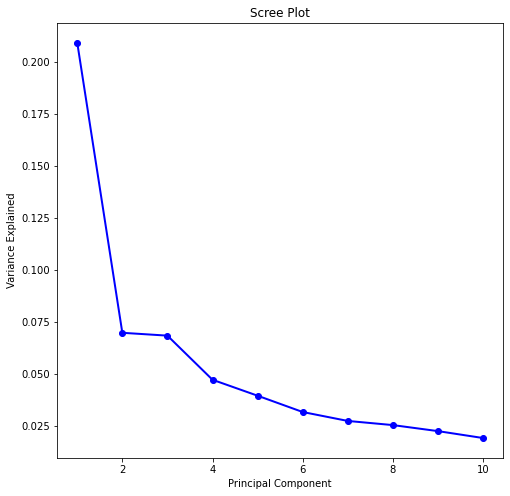

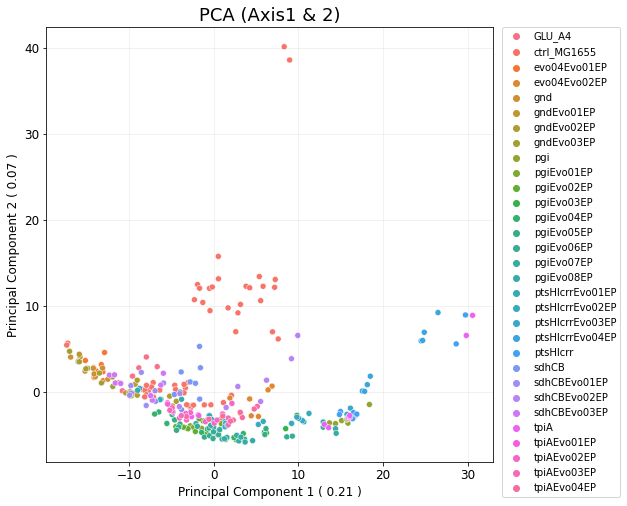

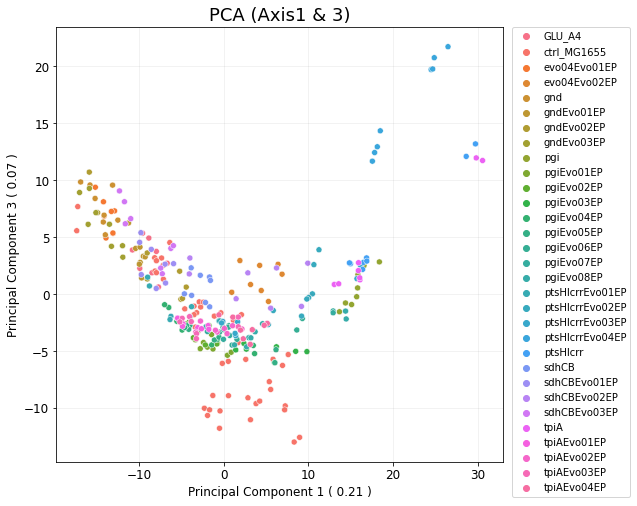

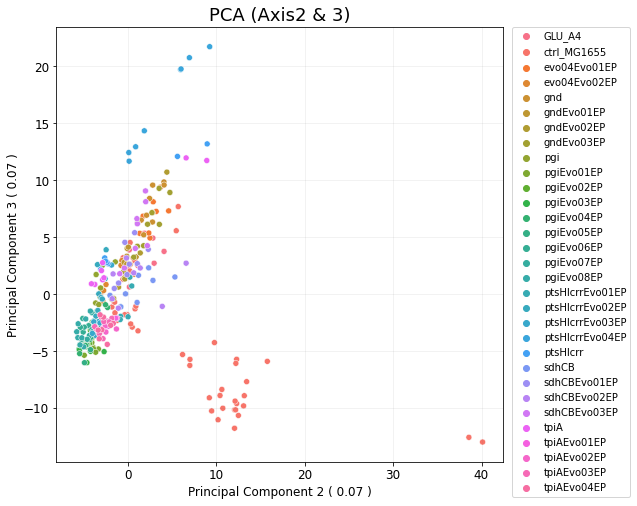

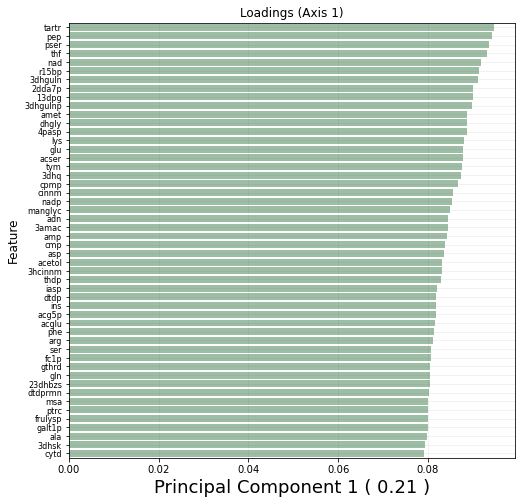

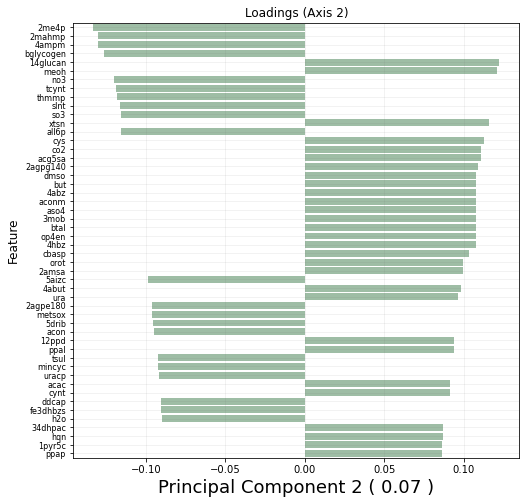

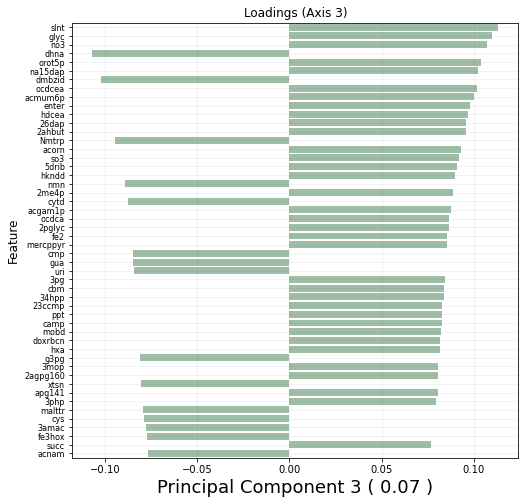

In [339]:
# Make the PCA plot with loadings plot and scree plot for axes 1 to 3
plotPCAwAnnotations(pca, scores.sort_values(by="replicate_group_name"), loadings, 3, 50, False, False)

## Statistical and pathway analyses

Hierarchical clustering analysis without pre-processing

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


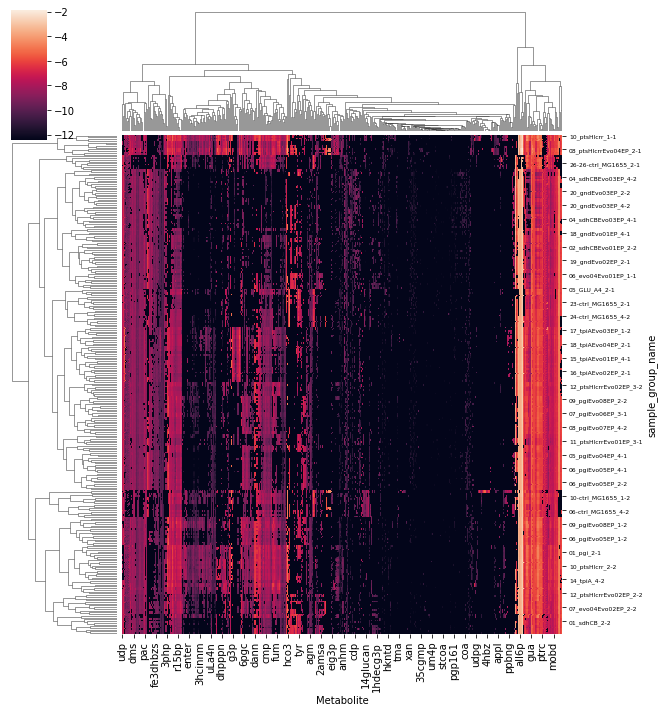

In [340]:
cm = sns.clustermap(intensities_piv, method="complete", metric="euclidean")
hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])

Clustering analysis with pre-processing using PCA

In [341]:
# Pre-process using PCA
intensities_piv_pca = pd.DataFrame(data = comps, columns =  ['PC1', 'PC2',
    'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
intensities_piv_pca.index = intensities_piv.index

In [342]:
# Create the ground truth labels
ord_enc = OrdinalEncoder()
labels_clust = ord_enc.fit_transform(scores[["replicate_group_name"]])
n_clust = len(np.unique(labels_clust))
print("n_clusters= ", n_clust)

# Create the clusters using AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=31, linkage="ward") # equivalent of KMeans
Y_preds = clustering.fit_predict(intensities_piv)
Y_preds_preprocessed = clustering.fit_predict(intensities_piv_pca) # with first 10 PCA dims

n_clusters=  31


In [343]:
# Determine the cluster qualty by computing several clustering scores on the original data...
ari = adjusted_rand_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds)
ami = adjusted_mutual_info_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds)
#si = silhouette_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds.reshape(-1,1), metric='euclidean')

# ... and preprocessed data
ari_preprocessed = adjusted_rand_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed)
ami_preprocessed = adjusted_mutual_info_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed)
#si_preprocessed = silhouette_score(labels_clust.reshape(labels_clust.shape[0]), Y_preds_preprocessed.reshape(-1,1), metric='euclidean')
print("adjusted rand index: %s, pre-processed %s", ari, ari_preprocessed)
print("adjusted mutual information: %s, pre-processed %s", ami, ami_preprocessed)
#print("silhouette score: %s, pre-processed %s", si, si_preprocessed)

adjusted rand index: %s, pre-processed %s 0.2981565444031168 0.2671361954413525
adjusted mutual information: %s, pre-processed %s 0.5832585147147265 0.5409551691233754


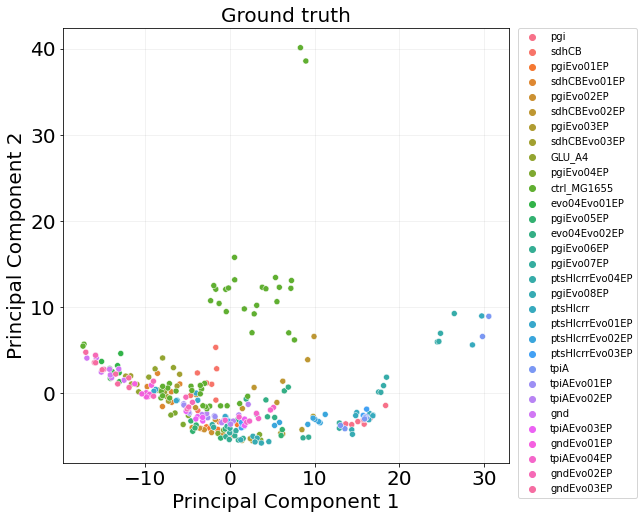

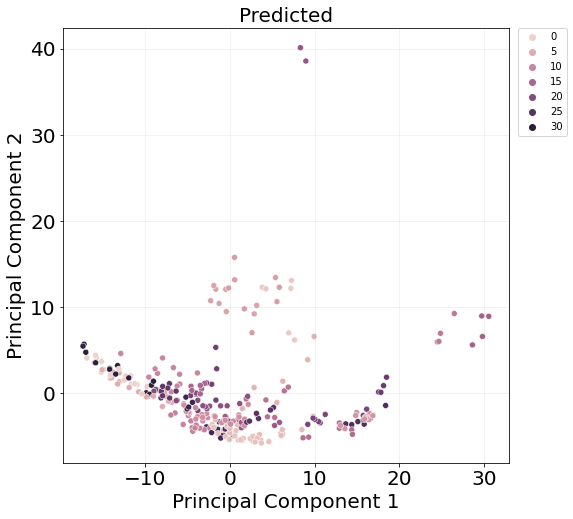

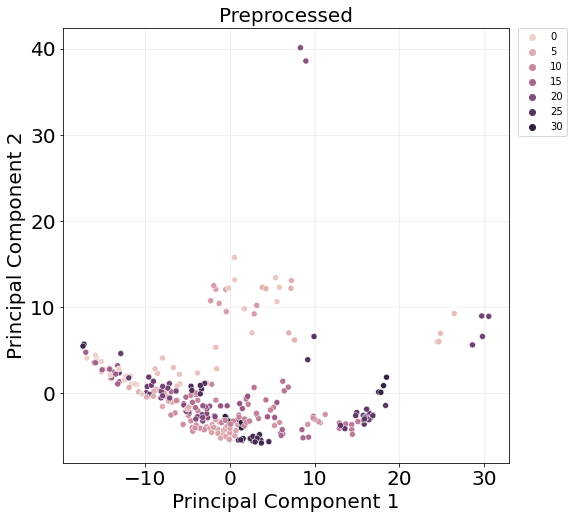

In [344]:
# Overlay of clusters onto PCs 1 and 2
for i in range(0, 3):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component ' + str(1), fontsize = 20)
    ax.set_ylabel('Principal Component ' + str(2), fontsize = 20)
    ax.set_title('Ground truth', fontsize = 20)

    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    if i==0:
        ax.set_title('Ground truth', fontsize = 20)
        sns.scatterplot(x=scores["PC" + str(1)], y=scores["PC" + str(2)],
            hue=scores["replicate_group_name"], ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    elif i==1:
        ax.set_title('Predicted', fontsize = 20)
        sns.scatterplot(x=scores["PC" + str(1)], y=scores["PC" + str(2)],
            hue=Y_preds, ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    elif i==2:
        ax.set_title('Preprocessed', fontsize = 20)
        sns.scatterplot(x=scores["PC" + str(1)], y=scores["PC" + str(2)],
            hue=Y_preds_preprocessed, ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


UMAP analysis; see https://umap-learn.readthedocs.io/en/latest

In [345]:
# Create embeddings using the UMAP algorithm
reducer = UMAP() # defaults
umap_embedding = reducer.fit_transform(intensities_piv)
umap_embedding_pca = reducer.fit_transform(intensities_piv_pca)

In [346]:
# Reformat the data structures
umap_plot = pd.DataFrame(data = umap_embedding, columns =  ['PC1', 'PC2'])
umap_plot["replicate_group_name"] = intensities_piv.index
umap_plot_pca = pd.DataFrame(data = umap_embedding_pca, columns =  ['PC1', 'PC2'])
umap_plot_pca["replicate_group_name"] = intensities_piv.index

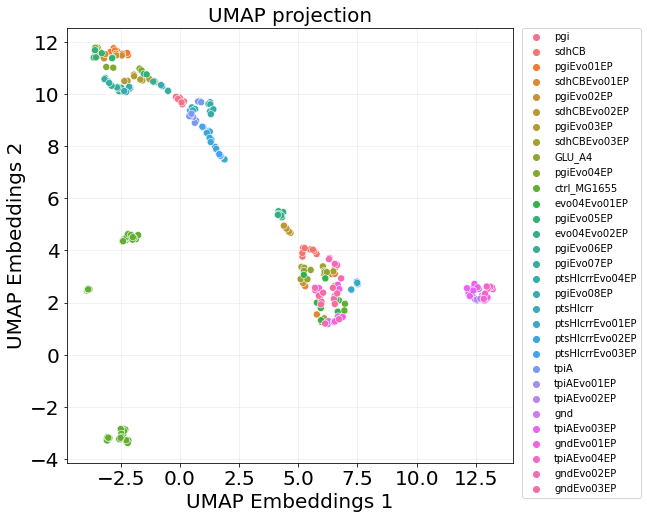

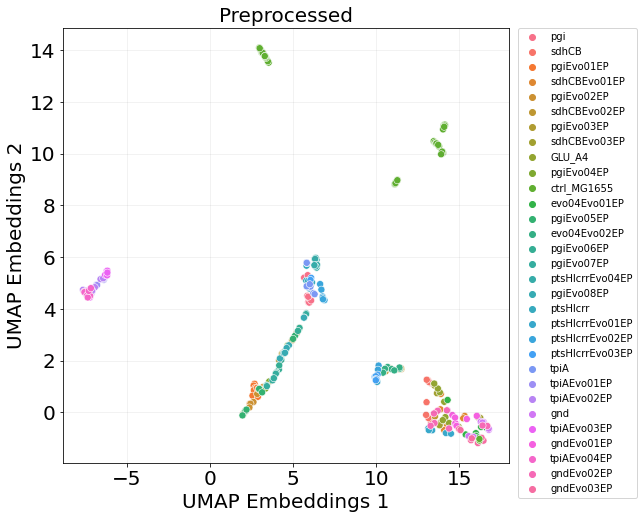

In [347]:
# Plot the first two embeddings
for i in range(0, 2):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('UMAP Embeddings ' + str(1), fontsize = 20)
    ax.set_ylabel('UMAP Embeddings ' + str(2), fontsize = 20)

    plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    if i==0:
        ax.set_title('UMAP projection', fontsize = 20)
        sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], s=50,
            hue=scores["replicate_group_name"], ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    elif i==1:
        ax.set_title('Preprocessed', fontsize = 20)
        sns.scatterplot(x=umap_embedding_pca[:, 0], y=umap_embedding_pca[:, 1], s=50,
            hue=scores["replicate_group_name"], ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Pathway enrichment analysis

In [348]:
# todo

Violin plots of individual metabolites of biological interest

In [349]:
# define the metabolites of biological interest
target_mets = []
if batch_name == "MetEngDemo":
    target_mets = database.loc[:,0].iloc[1180:]
elif batch_name == "NPDemo" or batch_name == "NatProdDemo":
    target_mets = database.loc[:,0].iloc[842:875] # [Leu-7]surfactin causes problems in python regex in pandas
elif batch_name == "KALEOnScale":
    select_mets = [#"23dpg","2mcit","2obut","35cgmp","5oxpro",
    "6pgc",#"AICAr",
    "glc",#__D",
    #"Lcystin","2pg",
    "accoa",#"acon__C","actp","ade","adn","adp","adpglc","akg","ala__L","amp",
    #"arg__L","asn__L","asp__L",
    "atp",
    "camp",#"chor","cit","citr__L","cmp","coa","ctp","cytd",
    #"dadp","damp","datp","dcdp","dcmp","dctp","dgdp","dgmp","dgtp","dhap","dimp","ditp",
    #"dtdpglu","dtmp","dttp","dump","dutp","f1p","f6p","fad",
    "fdp",#"fum","g1p","g3p",
    "all6p",
    #"gam6p","gdp","gln__L",
    "glu",#__L",#"glutacon","glx","glyc3p","glyclt","gmp","gsn","gthox",
    "gthrd",#"gtp","gua","his__L","hxan","icit","imp","ins","itp","lac__D","mal__L","malcoa",
    #"met__L","mmal","nadh","nad","nadph","nadp","oaa","orn","oxa",
    "pep",#"phe__L","phpyr",
    #"prpp","pyr","r5p","ru5p__D","s7p","ser__L","skm","succoa",
    "succ",#"thr__L","thym","trp__L",
    "tyr",#__L",#"udpglcur","udpg","udp","ump","urate","ura","uri","utp","xan"
    ]
    select_mets_set = set()
    for met_s in select_mets:
        for met_d in database.loc[:,0]:
            if met_d == met_s and met_s not in select_mets_set:
            #if met_d[:-2] == met_s and met_s not in select_mets_set:
                select_mets_set.add(met_s)
                target_mets.append(met_d)

# Filter out all other metabolites
violin_plot = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_subset["sample_group_name"].unique())
    & intensities_filtered_df["Metabolite"].isin(target_mets)
]

# Add in the replicate group name
violin_plot = addReplicateGroupNameToDF(violin_plot, sequence)

C:\Users\dmccl\AppData\Local\Temp\ipykernel_34472\2426977503.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = ""
C:\Users\dmccl\AppData\Local\Temp\ipykernel_34472\2426977503.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["replicate_group_name"] = df["sample_group_name"].apply(getRGNFromSeq, seq=sequence)


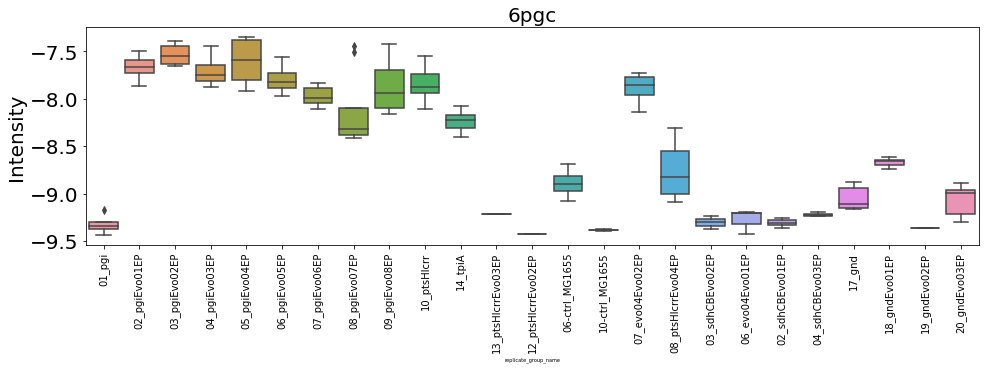

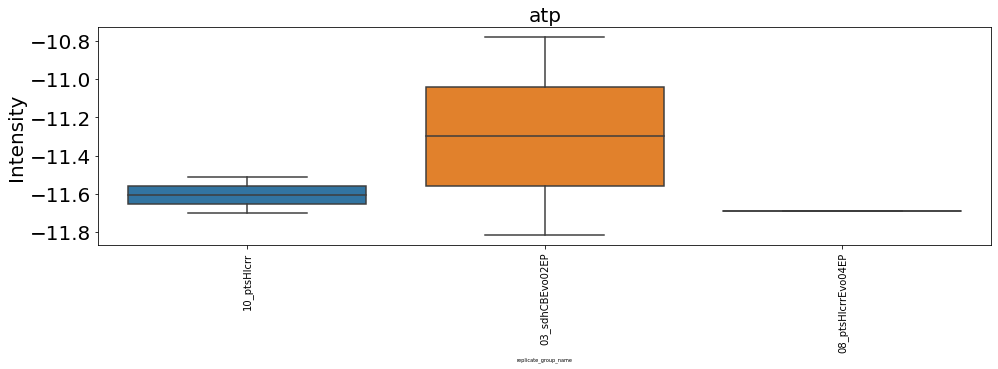

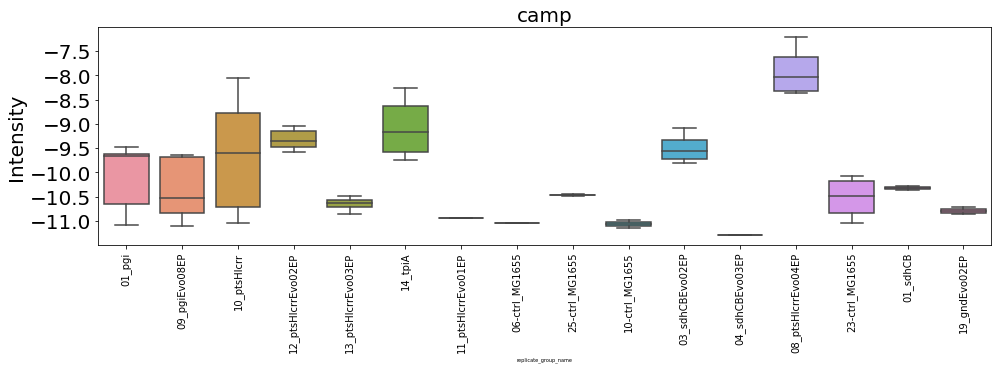

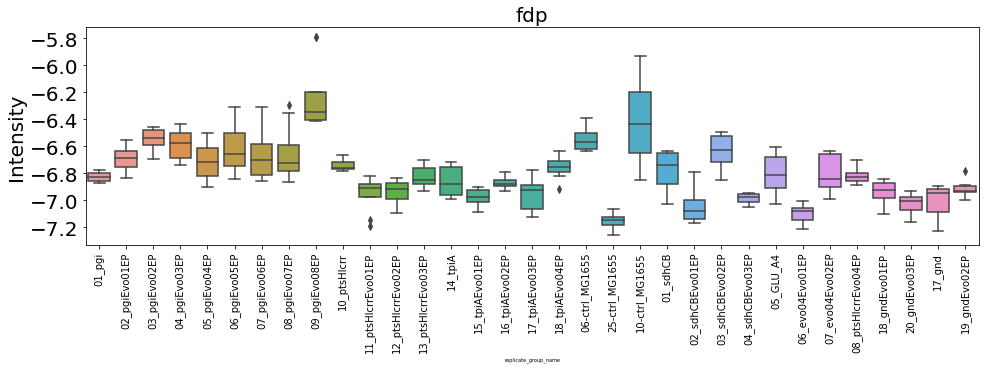

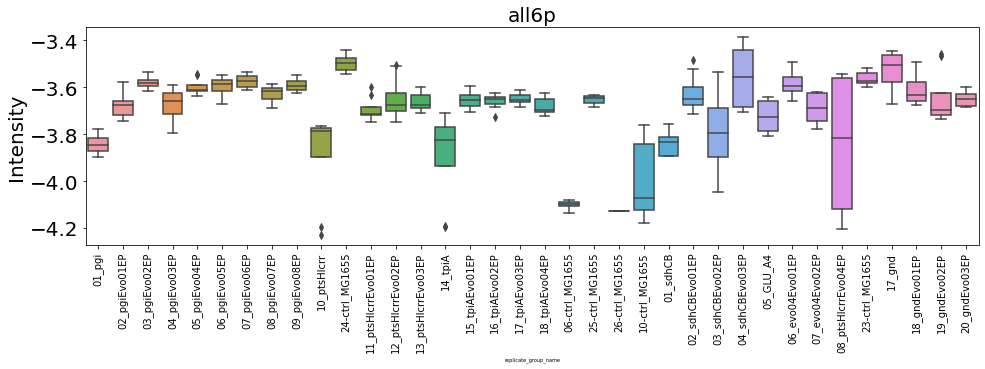

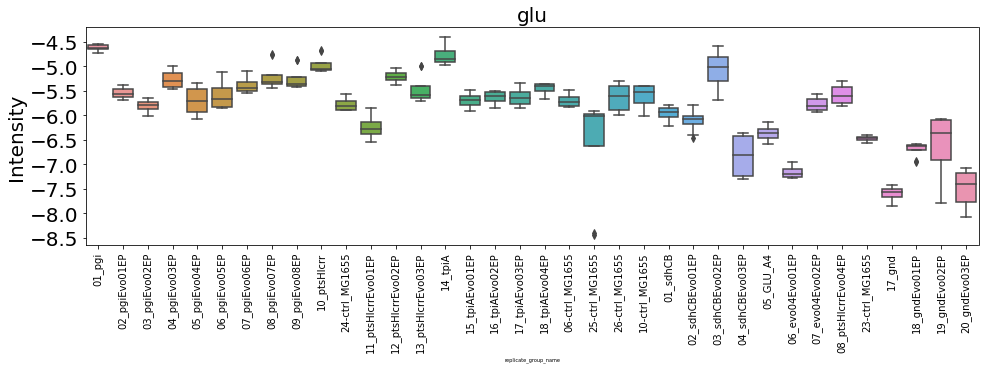

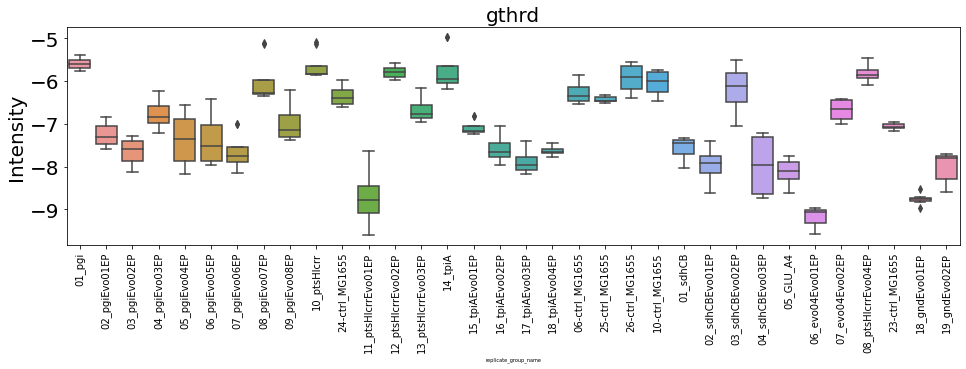

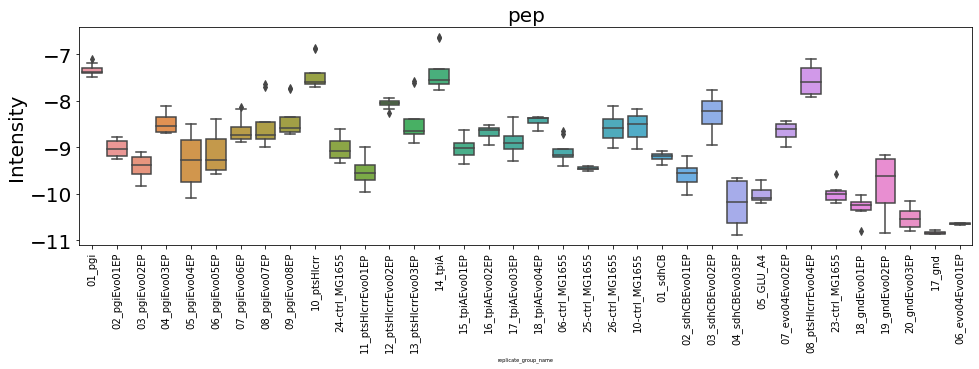

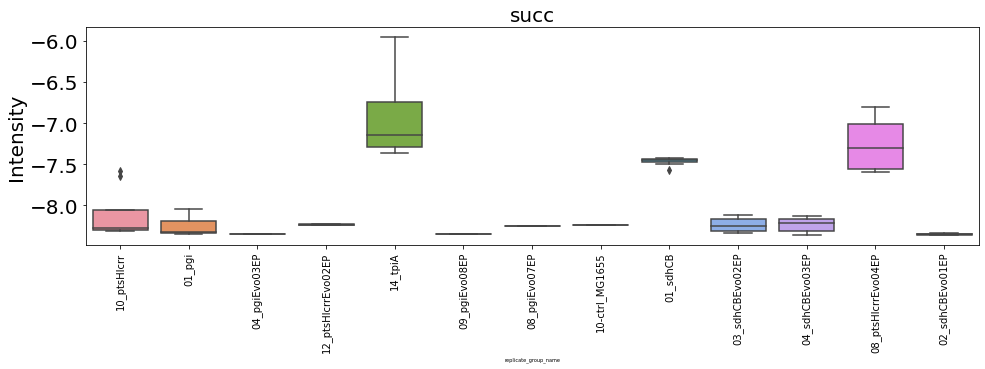

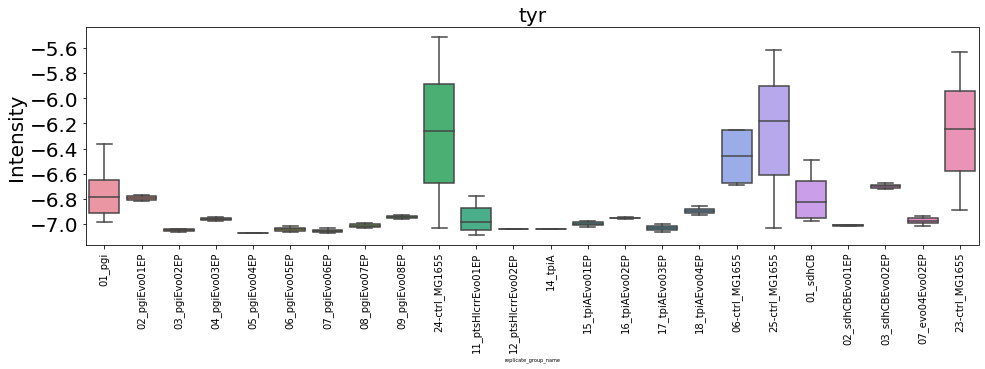

In [350]:
# Plot each of the metabolites of interest
for i in range(0, len(target_mets)):
    # violin_plot_subset = violin_plot[violin_plot["Metabolite"].str.contains(target_mets.iloc[i])]
    violin_plot_subset = violin_plot[violin_plot["Metabolite"].str.contains(target_mets[i])]
    if violin_plot_subset.shape[0] > 1:
        fig = plt.figure(figsize = (16,4))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('replicate_group_name', fontsize = 5)
        ax.set_ylabel('intensity', fontsize = 20)
        plt.xticks(rotation=90)
        plt.yticks(size = 20)
        # ax.set_title(target_mets.iloc[i], fontsize = 20)
        ax.set_title(target_mets[i], fontsize = 20)
        sns.boxplot(x="replicate_group_name", y="Intensity", data=violin_plot_subset, orient = 'v')

Statistical significance between groups

In [351]:
# Filter out other samples
intensities_plot = intensities_filtered_df[intensities_filtered_df["sample_group_name"].isin(sequence_subset["sample_group_name"].unique())
]

# Add in the replicate group name
intensities_plot = addReplicateGroupNameToDF(intensities_plot, sequence)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 <a list of 36 Text major ticklabel objects>)

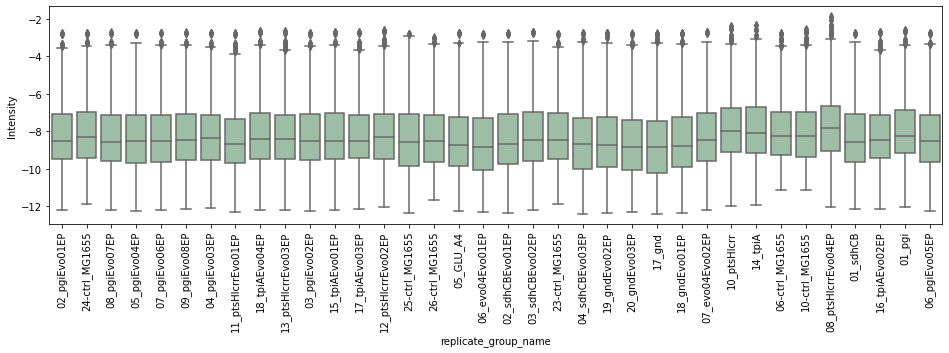

In [352]:
# box plot by conditions
fig = plt.figure(figsize = (16,4))
ax = sns.boxplot(x='replicate_group_name', y='Intensity', data=intensities_plot, color='#99c2a2')
#ax = sns.swarmplot(x="replicate_group_name", y="Intensity", data=intensities_plot, color='#7d0013')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

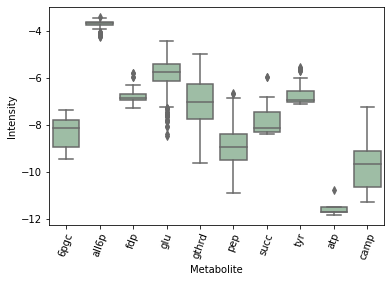

In [353]:
# box plot by metabolite
ax = sns.boxplot(x='Metabolite', y='Intensity', data=violin_plot, color='#99c2a2')
#ax = sns.swarmplot(x="Metabolite", y="Intensity", data=intensities_plot, color='#7d0013')
plt.xticks(rotation=70)

In [354]:
# # perform a two-way ANOVA
# model = ols('Intensity ~ C(replicate_group_name) + C(Metabolite) + C(replicate_group_name):C(Metabolite)', data=intensities_plot).fit()
# sm.stats.anova_lm(model, typ=2)

In [355]:
# perform multiple pairwise comparison (Tukey's HSD)
tukey_rgn = pairwise_tukeyhsd(endog=intensities_plot['Intensity'], groups=intensities_plot['replicate_group_name'], alpha=0.05)

# display results
print(tukey_rgn)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
            01_pgi           01_sdhCB  -0.3539 0.0001 -0.6173 -0.0905   True
            01_pgi      02_pgiEvo01EP  -0.3378 0.0004 -0.5982 -0.0774   True
            01_pgi    02_sdhCBEvo01EP   -0.433    0.0 -0.7038 -0.1622   True
            01_pgi      03_pgiEvo02EP  -0.3491 0.0002 -0.6121  -0.086   True
            01_pgi    03_sdhCBEvo02EP  -0.2716 0.0229 -0.5287 -0.0144   True
            01_pgi      04_pgiEvo03EP  -0.2576  0.041 -0.5114 -0.0037   True
            01_pgi    04_sdhCBEvo03EP  -0.5774    0.0 -0.8489  -0.306   True
            01_pgi          05_GLU_A4  -0.5203    0.0 -0.7859 -0.2548   True
            01_pgi      05_pgiEvo04EP  -0.4076    0.0 -0.6691 -0.1461   True
            01_pgi     06-ctrl_MG1655   -0.082    1.0 -0.3499  0.1858  False

Z-score

In [356]:
# Filter out other samples
intensities_stats_plot = intensities_stats[intensities_stats["replicate_group_name"].isin(sequence_subset["replicate_group_name"].unique())
]

# Calculate the z-score
z_scores = calcZScore(intensities_stats_plot, "Median")

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\weightstats.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  var_pooled = x1_var / (nobs1 - ddof)
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


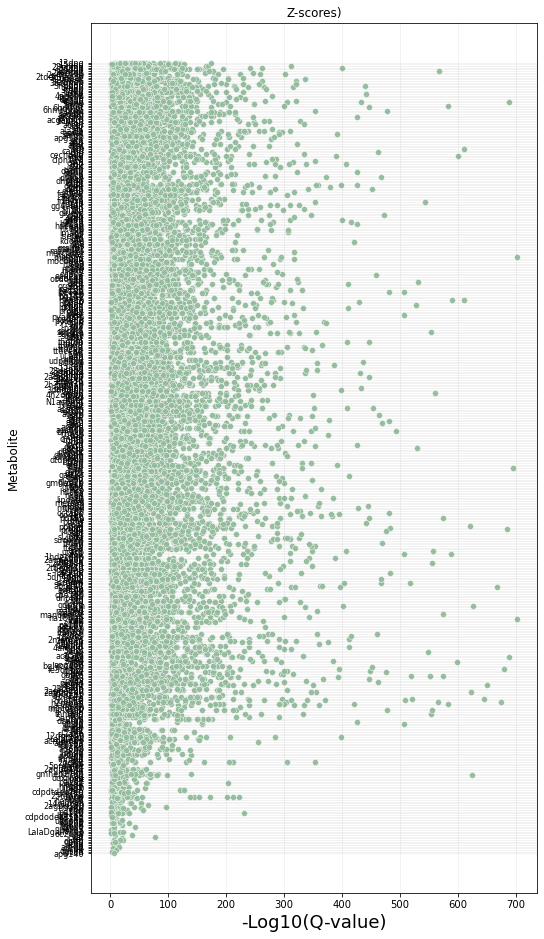

In [357]:
# Plot samples and features with significant z-scores
z_scores_plot = z_scores[z_scores["NegLog10QValue"]>=2.0]
fig = plt.figure(figsize = (8,16))
ax = fig.add_subplot(1,1,1) 
sns.scatterplot(x="NegLog10QValue", y="Metabolite", data=z_scores_plot, ax=ax, color='#99c2a2')
ax.set_xlabel('-Log10(Q-value)' , fontsize = 18)
ax.set_ylabel('Metabolite' , fontsize = 12)
ax.set_title('Z-scores)', fontsize = 12)
ax.tick_params(axis='y', labelsize=8)

plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)

Volcano plot

In [358]:
# Calculate the pairwise fold-change and p-value via a t-test
volcano_plot = calcVolcanoStats(intensities_plot, intensities_stats_plot, "Median", True, 2.0, 1.0)

c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
import sys
from matplotlib.colors import ListedColormap

In [ ]:
# Inspired by https://github.com/reneshbedre/bioinfokit

class general:
    def __init__(self):
        pass

    rand_colors = ('#a7414a', '#282726', '#6a8a82', '#a37c27', '#563838', '#0584f2', '#f28a30', '#f05837',
                   '#6465a5', '#00743f', '#be9063', '#de8cf0', '#888c46', '#c0334d', '#270101', '#8d2f23',
                   '#ee6c81', '#65734b', '#14325c', '#704307', '#b5b3be', '#f67280', '#ffd082', '#ffd800',
                   '#ad62aa', '#21bf73', '#a0855b', '#5edfff', '#08ffc8', '#ca3e47', '#c9753d', '#6c5ce7')

    @staticmethod
    def get_figure(show, r, figtype, fig_name, theme):
        if show:
            plt.show()
        else:
            plt.savefig(fig_name+'.'+figtype, format=figtype, bbox_inches='tight', dpi=r)
        if theme == 'dark':
            plt.style.use('default')
        plt.clf()
        plt.close()


    @staticmethod
    def axis_labels(x, y, axlabelfontsize=None, axlabelfontname=None):
        plt.xlabel(x, fontsize=axlabelfontsize, fontname=axlabelfontname)
        plt.ylabel(y, fontsize=axlabelfontsize, fontname=axlabelfontname)
        # plt.xticks(fontsize=9, fontname="sans-serif")
        # plt.yticks(fontsize=9, fontname="sans-serif")

    @staticmethod
    def axis_ticks(xlm=None, ylm=None, axtickfontsize=None, axtickfontname=None, ar=None):
        if xlm:
            plt.xlim(left=xlm[0], right=xlm[1])
            plt.xticks(np.arange(xlm[0], xlm[1], xlm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.xticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

        if ylm:
            plt.ylim(bottom=ylm[0], top=ylm[1])
            plt.yticks(np.arange(ylm[0], ylm[1], ylm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.yticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

    @staticmethod
    def check_for_nonnumeric(pd_series=None):
        if pd.to_numeric(pd_series, errors='coerce').isna().sum() == 0:
            return 0
        else:
            return 1

    @staticmethod
    def pvalue_symbol(pv=None, symbol=None):
        if 0.05 >= pv > 0.01:
            return symbol
        elif 0.01 >= pv > 0.001:
            return 2 * symbol
        elif pv <= 0.001:
            return 3 * symbol
        else:
            return None

    @staticmethod
    def dark_bg():
        plt.style.use('dark_background')

def gene_plot(d, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle):
        if genenames is not None and genenames == "deg":
            for i in d[geneid].unique():
                if (d.loc[d[geneid] == i, lfc].iloc[0] >= lfc_thr[0] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[0]) or \
                        (d.loc[d[geneid] == i, lfc].iloc[0] <= -lfc_thr[1] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[1]):
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is tuple:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is dict:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0],
                                      genenames[i], fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(genenames[i], xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)

def volcano(df="dataframe", lfc=None, pv=None, lfc_thr=(1, 1), pv_thr=(0.05, 0.05), color=("green", "grey", "red"),
                valpha=1, geneid=None, genenames=None, gfont=8, dim=(5, 5), r=300, ar=90, dotsize=8, markerdot="o",
                sign_line=False, gstyle=1, show=False, figtype='png', axtickfontsize=9,
                axtickfontname="Arial", axlabelfontsize=9, axlabelfontname="Arial", axxlabel=None,
                axylabel=None, xlm=None, ylm=None, plotlegend=False, legendpos='best',
                figname='volcano', legendanchor=None,
                legendlabels=['significant up', 'not significant', 'significant down'], theme=None):
        _x = r'$ log_{2}(Fold Change)$'
        _y = r'$ -log_{10}(P-value)$'
        color = color
        # check if dataframe contains any non-numeric character
        assert general.check_for_nonnumeric(df[lfc]) == 0, 'dataframe contains non-numeric values in lfc column'
        assert general.check_for_nonnumeric(df[pv]) == 0, 'dataframe contains non-numeric values in pv column'
        # this is important to check if color or logpv exists and drop them as if you run multiple times same command
        # it may update old instance of df
        df = df.drop(['color_add_axy', 'logpv_add_axy'], axis=1, errors='ignore')
        assert len(set(color)) == 3, 'unique color must be size of 3'
        df.loc[(df[lfc] >= lfc_thr[0]) & (df[pv] < pv_thr[0]), 'color_add_axy'] = color[0]  # upregulated
        df.loc[(df[lfc] <= -lfc_thr[1]) & (df[pv] < pv_thr[1]), 'color_add_axy'] = color[2]  # downregulated
        df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
        df['logpv_add_axy'] = -(np.log10(df[pv]))
        # plot
        assign_values = {col: i for i, col in enumerate(color)}
        color_result_num = [assign_values[i] for i in df['color_add_axy']]
        assert len(set(color_result_num)) == 3, \
            'either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include ' \
            'both significant and non-significant genes'
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        if plotlegend:
            s = plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                            s=dotsize, marker=markerdot)
            assert len(legendlabels) == 3, 'legendlabels must be size of 3'
            plt.legend(handles=s.legend_elements()[0], labels=legendlabels, loc=legendpos, bbox_to_anchor=legendanchor)
        else:
            plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                        s=dotsize, marker=markerdot)
        if sign_line:
            plt.axhline(y=-np.log10(pv_thr[0]), linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=lfc_thr[0], linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=-lfc_thr[1], linestyle='--', color='#7d7d7d', linewidth=1)
        gene_plot(df, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle)

        if axxlabel:
            _x = axxlabel
        if axylabel:
            _y = axylabel
        general.axis_labels(_x, _y, axlabelfontsize, axlabelfontname)
        general.axis_ticks(xlm, ylm, axtickfontsize, axtickfontname, ar)
        general.get_figure(show, r, figtype, figname, theme)

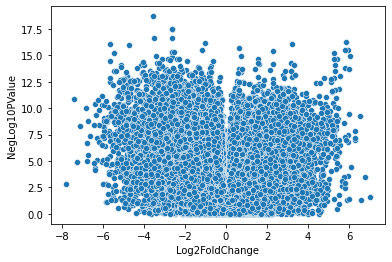

In [ ]:
tmp = volcano_plot[(~volcano_plot["NegLog10PValue"].isnull()) & (~volcano_plot["Log2FoldChange"].isnull())]
#volcano(df=tmp, lfc='Log2FoldChange', pv='NegLog10PValue', show=True, geneid="Metabolite")
sns.scatterplot(x='Log2FoldChange', y='NegLog10PValue', data=tmp)